# Optimizing the Cleveland Indians' 2018 Batting Order

The Cleveland Indians are in a strong position to compete in 2018. They are coming off of a very strong 2 year stretch and seem to have good control of the AL Central division. However, anything can happen in baseball and it would be smart for the Tribe to look for any edge they can manage. This is an analysis of the optimization of Cleveland's 2018 batting lineup, attempting to show one way that the Indians could maximize their run differential.

I will be diving deep into the play-by-play data from the 2017 MLB season (provided by retrosheet).

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [6]:
advanced = pd.read_csv('Advanced.csv')
batted_ball = pd.read_csv('Batted Ball.csv')
dashboard = pd.read_csv('Dashboard.csv')
plate_discipline = pd.read_csv('Plate Discipline.csv')
standard = pd.read_csv('Standard.csv')
BR = pd.read_csv('BR.csv')
april = pd.read_csv('events_apr.csv')
may = pd.read_csv('events_may.csv')
june = pd.read_csv('events_jun.csv')
july = pd.read_csv('events_jul.csv')
august = pd.read_csv('events_aug.csv')
september = pd.read_csv('events_sep.csv')

C:\Users\Michael\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (86) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Player Projections

To aid in predicting player performance, I will be using Fangraphs projections for 2018. Although we are using 2017 play-by-play data and I could use player performance from 2017 to predict how they will perform in 2018, the projections are a better bet. This is because they take multiple years into account to arrive at a reasonable prediction without putting too much stock into one good or bad year.

Read up about the methodology here:
https://www.fangraphs.com/library/principles/projections/

In [17]:
proj = pd.read_csv('CLE_Proj.csv')
proj.head()

,Name,Team,G,PA,AB,H,2B,3B,HR,R,RBI,BB,SO,HBP,SB,CS,AVG,OBP,SLG,OPS,wOBA,Fld,BsR,WAR,ADP,playerid
0,Edwin Encarnacion,Indians,155,651,550,139,25,1,38,94,107,89,134,6,2,1,0.253,0.360,0.506,0.866,0.366,0.0,-2.8,2.6,56.4,2151
1,Francisco Lindor,Indians,158,665,594,175,35,3,26,99,89,58,83,4,15,7,0.294,0.358,0.493,0.851,0.360,13.4,0.1,6.2,20.9,12916
2,Jose Ramirez,Indians,158,665,599,178,44,4,22,93,93,55,68,4,18,9,0.297,0.358,0.492,0.850,0.359,4.2,1.2,4.9,19.1,13510
3,Michael Brantley,Indians,128,539,480,141,31,1,16,71,71,50,70,3,10,4,0.293,0.360,0.462,0.823,0.350,-2.7,0.7,2.0,246.7,4106
4,Yonder Alonso,Indians,133,560,488,132,27,1,20,71,74,63,107,3,3,2,0.270,0.355,0.453,0.807,0.345,0.8,-1.5,1.7,301.0,2530


## Event Percentages

To gain an estimate for how productive a given Indians lineup will be, I will create simulated innings. To build out the first step for this, I will use the projections to my advantage. Each plate appearance will be broken down into 8 possible events: single, double, triple, home run, walk, hit by pitch, strikeout, or generic out. Those are the relevant batting events out of the 25 total possible events codes in the data.

First is to add a column for each player to the proj dataframe which is a proportion of PA that each of those events is projected to occur. When a player comes to the plate in the simulation, an event will be randomly chosen from the set of 8 outcomes based on the players event probability set. For example, based on the projections, Edwin Encarnacion will hit a single in about 11.5% of PA, and so that will be his chance to hit one in the sim.

In [19]:
proj['1B'] = proj['H']-proj['2B']-proj['3B']-proj['HR']
proj['GO'] = proj['PA']-proj['H']-proj['SO']-proj['BB']-proj['HBP']

In [20]:
events = ['1B','2B','3B','HR','BB','SO','HBP','GO']
def event_pct(event):
    proj[event+'%'] = proj[event]/proj['PA']

for event in events:
    event_pct(event)

In [21]:
proj.head()

,Name,Team,G,PA,AB,H,2B,3B,HR,R,RBI,BB,SO,HBP,SB,CS,AVG,OBP,SLG,OPS,wOBA,Fld,BsR,WAR,ADP,playerid,1B,GO,1B%,2B%,3B%,HR%,BB%,SO%,HBP%,GO%
0,Edwin Encarnacion,Indians,155,651,550,139,25,1,38,94,107,89,134,6,2,1,0.253,0.360,0.506,0.866,0.366,0.0,-2.8,2.6,56.4,2151,75,283,0.115207,0.038402,0.001536,0.058372,0.136713,0.205837,0.009217,0.434716
1,Francisco Lindor,Indians,158,665,594,175,35,3,26,99,89,58,83,4,15,7,0.294,0.358,0.493,0.851,0.360,13.4,0.1,6.2,20.9,12916,111,345,0.166917,0.052632,0.004511,0.039098,0.087218,0.124812,0.006015,0.518797
2,Jose Ramirez,Indians,158,665,599,178,44,4,22,93,93,55,68,4,18,9,0.297,0.358,0.492,0.850,0.359,4.2,1.2,4.9,19.1,13510,108,360,0.162406,0.066165,0.006015,0.033083,0.082707,0.102256,0.006015,0.541353
3,Michael Brantley,Indians,128,539,480,141,31,1,16,71,71,50,70,3,10,4,0.293,0.360,0.462,0.823,0.350,-2.7,0.7,2.0,246.7,4106,93,275,0.172542,0.057514,0.001855,0.029685,0.092764,0.129870,0.005566,0.510204
4,Yonder Alonso,Indians,133,560,488,132,27,1,20,71,74,63,107,3,3,2,0.270,0.355,0.453,0.807,0.345,0.8,-1.5,1.7,301.0,2530,84,255,0.150000,0.048214,0.001786,0.035714,0.112500,0.191071,0.005357,0.455357


In [22]:
probs = ['1B%','2B%','3B%','HR%','BB%','SO%','HBP%','GO%']
def player_rand_event(player):
    return np.random.choice(events,1,p=(proj[proj['Name'] == player][probs].values.ravel()))[0]

In [23]:
player_rand_event('Edwin Encarnacion')

'SO'

An example set of 1000 simulated PAs for Encarnacion

In [24]:
PA_event = []
for PA in range(0,1000):
    PA_event.append(player_rand_event('Edwin Encarnacion'))
for i in events:
    print(i+':')
    print(PA_event.count(i))

1B:
119
2B:
41
3B:
1
HR:
51
BB:
141
SO:
202
HBP:
8
GO:
437


## Play-by-Play Data

Below is a sample of what the data looks like. It features in depth play-by-play information for each occurrence throughout the 2017 MLB season.

In [7]:
pbp = april
pbp = pbp.append(may).append(june).append(july).append(august).append(september)

pd.set_option('display.max_columns', 200)
pbp.head(5)

,GAME_ID,YEAR_ID,AWAY_TEAM_ID,INN_CT,BAT_HOME_ID,OUTS_CT,BALLS_CT,STRIKES_CT,PITCH_SEQ_TX,AWAY_SCORE_CT,HOME_SCORE_CT,BAT_ID,BAT_HAND_CD,RESP_BAT_ID,RESP_BAT_HAND_CD,PIT_ID,PIT_HAND_CD,RES_PIT_ID,RES_PIT_HAND_CD,POS2_FLD_ID,POS3_FLD_ID,POS4_FLD_ID,POS5_FLD_ID,POS6_FLD_ID,POS7_FLD_ID,POS8_FLD_ID,POS9_FLD_ID,BASE1_RUN_ID,BASE2_RUN_ID,BASE3_RUN_ID,EVENT_TX,LEADOFF_FL,PH_FL,BAT_FLD_CD,BAT_LINEUP_ID,EVENT_CD,BAT_EVENT_FL,AB_FL,H_CD,SH_FL,SF_FL,EVENT_OUTS_CT,DP_FL,TP_FL,RBI_CT,WP_FL,PB_FL,FLD_CD,BATTEDBALL_CD,BUNT_FL,FOUL_FL,BATTEDBALL_LOC_TX,ERR_CT,ERR1_FLD_CD,ERR1_CD,ERR2_FLD_CD,ERR2_CD,ERR3_FLD_CD,ERR3_CD,BAT_DEST_ID,RUN1_DEST_ID,RUN2_DEST_ID,RUN3_DEST_ID,BAT_PLAY_TX,RUN1_PLAY_TX,RUN2_PLAY_TX,RUN3_PLAY_TX,RUN1_SB_FL,RUN2_SB_FL,RUN3_SB_FL,RUN1_CS_FL,RUN2_CS_FL,RUN3_CS_FL,RUN1_PK_FL,RUN2_PK_FL,RUN3_PK_FL,RUN1_RESP_PIT_ID,RUN2_RESP_PIT_ID,RUN3_RESP_PIT_ID,GAME_NEW_FL,GAME_END_FL,PR_RUN1_FL,PR_RUN2_FL,PR_RUN3_FL,REMOVED_FOR_PR_RUN1_ID,REMOVED_FOR_PR_RUN2_ID,REMOVED_FOR_PR_RUN3_ID,REMOVED_FOR_PH_BAT_ID,REMOVED_FOR_PH_BAT_FLD_CD,PO1_FLD_CD,PO2_FLD_CD,PO3_FLD_CD,ASS1_FLD_CD,ASS2_FLD_CD,ASS3_FLD_CD,ASS4_FLD_CD,ASS5_FLD_CD,EVENT_ID,HOME_TEAM_ID,BAT_TEAM_ID,FLD_TEAM_ID,BAT_LAST_ID,INN_NEW_FL,INN_END_FL,START_BAT_SCORE_CT,START_FLD_SCORE_CT,INN_RUNS_CT,GAME_PA_CT,INN_PA_CT,PA_NEW_FL,PA_TRUNC_FL,START_BASES_CD,END_BASES_CD,BAT_START_FL,RESP_BAT_START_FL,BAT_ON_DECK_ID,BAT_IN_HOLD_ID,PIT_START_FL,RESP_PIT_START_FL,RUN1_FLD_CD,RUN1_LINEUP_ID,RUN1_ORIGIN_EVENT_ID,RUN2_FLD_CD,RUN2_LINEUP_ID,RUN2_ORIGIN_EVENT_ID,RUN3_FLD_CD,RUN3_LINEUP_ID,RUN3_ORIGIN_EVENT_ID,RUN1_RESP_CATCH_ID,RUN2_RESP_CATCH_ID,RUN3_RESP_CATCH_ID,PA_BALL_CT,PA_CALLED_BALL_CT,PA_INTENT_BALL_CT,PA_PITCHOUT_BALL_CT,PA_HIT_BALL_CT,PA_OTHER_BALL_CT,PA_STRIKE_CT,PA_CALLED_STRIKE_CT,PA_SWINGMISS_STRIKE_CT,PA_FOUL_STRIKE_CT,PA_BIP_STRIKE_CT,PA_OTHER_STRIKE_CT,EVENT_RUNS_CT,FLD_ID,BASE2_FORCE_FL,BASE3_FORCE_FL,BASE4_FORCE_FL,BAT_SAFE_ERR_FL,BAT_FATE_ID,RUN1_FATE_ID,RUN2_FATE_ID,RUN3_FATE_ID,FATE_RUNS_CT,ASS6_FLD_CD,ASS7_FLD_CD,ASS8_FLD_CD,ASS9_FLD_CD,ASS10_FLD_CD,UNKNOWN_OUT_EXC_FL,UNCERTAIN_PLAY_EXC_FL
0,ARI201704020,2017,SFN,1,0,0,1,1,CBX,0,0,spand001,L,spand001,L,greiz001,R,greiz001,R,mathj001,goldp001,drurb001,lambj001,owinc001,tomay001,polla001,perad001,NaN,NaN,NaN,NaN,T,F,8,1,2,T,T,0,F,F,1,F,F,0,F,F,0,P,F,F,NaN,0,0,N,0,N,0,N,0,0,0,0,NaN,NaN,NaN,NaN,F,F,F,F,F,F,F,F,F,NaN,NaN,NaN,T,F,F,F,F,NaN,NaN,NaN,NaN,0,6,0,0,0,0,0,0,0,1,ARI,SFN,ARI,0,T,F,0,0,0,0,0,T,F,0,0,T,T,beltb001,pench001,T,T,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,1,0,0,0,0,2,1,0,0,1,0,0,NaN,F,F,F,F,0,0,0,0,0,0,0,0,0,0,F,F
1,ARI201704020,2017,SFN,1,0,1,3,2,FFBBBB,0,0,beltb001,L,beltb001,L,greiz001,R,greiz001,R,mathj001,goldp001,drurb001,lambj001,owinc001,tomay001,polla001,perad001,NaN,NaN,NaN,NaN,F,F,3,2,14,T,F,0,F,F,0,F,F,0,F,F,0,NaN,F,F,NaN,0,0,N,0,N,0,N,1,0,0,0,NaN,NaN,NaN,NaN,F,F,F,F,F,F,F,F,F,NaN,NaN,NaN,F,F,F,F,F,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,2,ARI,SFN,ARI,0,F,F,0,0,0,1,1,T,F,0,1,T,T,pench001,poseb001,T,T,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,4,4,0,0,0,0,2,0,0,2,0,0,0,NaN,F,F,F,F,2,0,0,0,0,0,0,0,0,0,F,F
2,ARI201704020,2017,SFN,1,0,1,1,1,BSX,0,0,pench001,R,pench001,R,greiz001,R,greiz001,R,mathj001,goldp001,drurb001,lambj001,owinc001,tomay001,polla001,perad001,beltb001,NaN,NaN,NaN,F,F,9,3,20,T,T,1,F,F,0,F,F,0,F,F,8,G,F,F,NaN,0,0,N,0,N,0,N,1,2,0,0,NaN,NaN,NaN,NaN,F,F,F,F,F,F,F,F,F,greiz001,NaN,NaN,F,F,F,F,F,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,3,ARI,SFN,ARI,0,F,F,0,0,0,2,2,T,F,1,3,T,T,poseb001,crawb001,T,T,3,2,2,0,0,0,0,0,0,mathj001,NaN,NaN,1,1,0,0,0,0,2,0,1,0,1,0,0,polla001,F,F,F,F,1,2,0,0,0,0,0,0,0,0,F,F
3,ARI201704020,2017,SFN,1,0,1,1,2,*BFCC,0,0,poseb001,R,poseb001,R,greiz001,R,greiz001,R,mathj001,goldp001,drurb001,lambj001,owinc001,tomay001,polla001,perad001,pench001,beltb001,NaN,K,F,F,2,4,3,T,T,0,F,F,1,F,F,0,F,F,0,NaN,F,F,NaN,0,0,N,0,N,0,N,0,1,2,0,2.0,NaN,NaN,NaN,F,F,F,F,F,F,F,F,F,greiz001,greiz001,NaN,F,F,F,F,F,NaN,NaN,NaN,NaN,0,2,0,0,0,0,0,0,0,4,ARI,SFN,ARI,0,F,F,0,0,0,3,3,T,F,3,3,T,T,crawb001,nunee002,T,T,9,3,3,3,2,2,0,0,0,m

Identifying half innings, runs scored in each half inning. Mapping base state codes to readable format for presentation.

In [8]:
pbp = pbp.rename(columns=lambda x: x.strip())

In [9]:
pbp['HALF_INN_ID'] = pbp['GAME_ID'].map(str)+pbp['INN_CT'].map(str)+pbp['BAT_HOME_ID'].map(str)
end_of_inning = pbp[pbp['INN_END_FL'] == 'T']

half_innings = list(end_of_inning['HALF_INN_ID'])
inn_end_scores = list(end_of_inning['INN_RUNS_CT'])
inn_end_scores_dict = dict(zip(half_innings, inn_end_scores))

In [10]:
base_state_dict = {0:'Empty',1:'1B _ _',2:'_ 2B _',3:'1B 2B _',
                  4: '_ _ 3B',5:'1B _ 3B',6:'_ 2B 3B',7:'1B 2B 3B'}

In [11]:
pbp['BASE_STATE'] = pbp['START_BASES_CD'].map(base_state_dict)
pbp['END_BASE_STATE'] = pbp['END_BASES_CD'].map(base_state_dict)
pbp['END_OUTS_CT'] = pbp['OUTS_CT'] + pbp['EVENT_OUTS_CT']

In [12]:
event_code_dict = {0:'Unknown event',1:'No event',2:'Generic out',3:'Strikeout',4:'Stolen base',5:'Defensive indifference',
                  6:'Caught stealing',7:'Pickoff error',8:'Pickoff',9:'Wild pitch',10:'Passed ball',11:'Balk',12:'Other advance',
                  13:'Foul error',14:'Walk',15:'Intentional walk',16:'Hit by pitch',17:'Interference',18:'Error',
                   19:'Fielders choice',20:'Single',21:'Double',22:'Triple',23:'Home Run',24:'Missing play'}
pbp['EVENT_STR'] = pbp['EVENT_CD'].map(event_code_dict)

## Determining Event Outcomes

I have discussed how an event will randomly be chosen during each simulated plate appearance depending on the player who is up. Each PA will also have a certain base-out-state, or how many runners are on base (and where) and how many outs there are.

The question is, when one of those events occurs, how should the exact outcome of the play be determined? Some plays are a guarantee; if a player draws a walk, he is awarded first base and other players advance accordingly, and there is only one possible outcome for any initial base-out state. However, if the bases are loaded and the batter hits a single, what should happen in the simulation? One runner scores and bases remain loaded? Two runners score and runners on the corners? This is where the play by play data comes in. To answer this question, we find every situation where a single was hit with the bases loaded with a certain number of outs and count up the different outcomes. From the relative frequency of the outcomes we can give each one a probability. The simulation will use these probablities to choose what outcome occurs from a given event.

Below is the play by play data grouped by the initial base-out state, the event, and the outcome in base state, outs, and runs. This can be used to get the set of outcomes and probabilites for each possible situation/event combination. 

In [13]:
pd.set_option('display.max_rows', 500)
state_change = pbp.groupby(['BASE_STATE','OUTS_CT','EVENT_STR','END_BASE_STATE','END_OUTS_CT','EVENT_RUNS_CT']).size()
state_change

BASE_STATE  OUTS_CT  EVENT_STR               END_BASE_STATE  END_OUTS_CT  EVENT_RUNS_CT
1B 2B 3B    0        Balk                    _ 2B 3B         0            1                   1
                     Double                  Empty           1            3                   1
                                             _ 2B 3B         0            2                  24
                                             _ 2B _          0            3                   9
                                                             1            2                   1
                     Error                   1B 2B 3B        0            1                   9
                                             1B 2B _         0            2                   2
                                             1B _ 3B         0            2                   1
                     Fielders choice         1B 2B 3B        0            1                   1
                     Generic out             1B 

In [337]:
# TF = []
# for i in range(0,8):
#     for j in range(0,3):
#         for event in events:
#             TF.append(event in (pbp.groupby(['START_BASES_CD','OUTS_CT'])['EVENT_ABBR'].unique()[i][j]))
# False in TF

False

In [14]:
event_ct = pbp.groupby(['BASE_STATE','OUTS_CT','EVENT_STR']).size()

In [15]:
def event_prob(start_base_state,start_out,event):
    return state_change[start_base_state][start_out][event]/event_ct[start_base_state][start_out][event]

## Outcome Probability Example

Below is the outcome probability set for the bases loaded, 0 out single situation discussed above.

In [16]:
event_prob('1B 2B 3B',0,'Single')

END_BASE_STATE  END_OUTS_CT  EVENT_RUNS_CT
1B 2B 3B        0            1                0.491379
1B 2B _         0            2                0.336207
1B _ 3B         0            2                0.112069
                1            1                0.008621
1B _ _          1            2                0.025862
_ 2B 3B         0            2                0.025862
dtype: float64

In [18]:
pbp['EVENT_STR'].unique()

array(['Generic out', 'Walk', 'Single', 'Strikeout', 'Stolen base',
       'Double', 'Home Run', 'Other advance', 'Triple', 'Caught stealing',
       'Wild pitch', 'Defensive indifference', 'Hit by pitch',
       'Intentional walk', 'Error', 'Fielders choice', 'Interference',
       'Pickoff', 'Passed ball', 'Balk', 'Foul error'], dtype=object)

In [25]:
proj[proj['Name'] == 'Edwin Encarnacion'][probs]

,1B%,2B%,3B%,HR%,BB%,SO%,HBP%,GO%
0,0.115207,0.038402,0.001536,0.058372,0.136713,0.205837,0.009217,0.434716


In [26]:
proj[proj['Name'] == 'Edwin Encarnacion'][probs].values.ravel()

array([ 0.11520737,  0.03840246,  0.0015361 ,  0.05837174,  0.13671275,
        0.20583717,  0.00921659,  0.43471582])

In [27]:
event_code_dict = {0:'Unknown event',1:'No event',2:'GO',3:'SO',4:'Stolen base',5:'Defensive indifference',
                  6:'Caught stealing',7:'Pickoff error',8:'Pickoff',9:'Wild pitch',10:'Passed ball',11:'Balk',12:'Other advance',
                  13:'Foul error',14:'BB',15:'Intentional walk',16:'HBP',17:'Interference',18:'Error',
                   19:'Fielders choice',20:'1B',21:'2B',22:'3B',23:'HR',24:'Missing play'}
pbp['EVENT_ABBR'] = pbp['EVENT_CD'].map(event_code_dict)

In [32]:
event_prob('1B 2B 3B',0,'1B').index

MultiIndex(levels=[['1B 2B 3B', '1B 2B _', '1B _ 3B', '1B _ _', 'Empty', '_ 2B 3B', '_ 2B _', '_ _ 3B'], [0, 1, 2, 3], [0, 1, 2, 3, 4]],
           labels=[[0, 1, 2, 2, 3, 5], [0, 0, 0, 1, 1, 0], [1, 2, 2, 1, 2, 2]],
           names=['END_BASE_STATE', 'END_OUTS_CT', 'EVENT_RUNS_CT'])

In [33]:
event_prob('1B 2B 3B',0,'1B').index[0][0]

'1B 2B 3B'

In [34]:
len(event_prob('1B 2B 3B',0,'1B').values)

6

#### Event_Outcome Function

The event_outcome function is given an initial base-out-state and an event (which has been randomly chosen based on the player) and randomly chooses an outcome based on the outcome probability space for those three inputs. An example is given for a Francisco Lindor PA.

In [35]:
def event_outcome(start_base,start_out,event):
    outcomes = event_prob(start_base,start_out,event)
    num = np.random.choice(range(0,len(outcomes.values)),1,p=outcomes.values)[0]
    end_base = outcomes.index[num][0]
    end_out = outcomes.index[num][1]
    runs = outcomes.index[num][2]
    return end_base,end_out,runs

In [36]:
player_rand_event('Francisco Lindor')

'GO'

In [37]:
event_outcome('Empty',0,player_rand_event('Francisco Lindor'))

('1B _ _', 0, 0)

#### PA Function

The PA function is given a player and a base-out situation and combines the random selections for the event and the outcome to give the total PA.

In [38]:
def PA(player,start_base,start_out):
    event = player_rand_event(player)
    outcome = event_outcome(start_base,start_out,event)
    return event,outcome

In [40]:
PA('Michael Brantley','1B 2B 3B',0)

('1B', ('1B 2B 3B', 0, 1))

In [41]:
proj['Name']

0     Edwin Encarnacion
1      Francisco Lindor
2          Jose Ramirez
3      Michael Brantley
4         Yonder Alonso
5            Yandy Diaz
6     Lonnie Chisenhall
7          Jason Kipnis
8         Brandon Guyer
9          Tyler Naquin
10      Abraham Almonte
11      Francisco Mejia
12       Bradley Zimmer
13        Roberto Perez
14            Yan Gomes
15           Greg Allen
16     Giovanny Urshela
17     Melvin Upton Jr.
18           Eric Haase
19        Erik Gonzalez
20       Yu-Cheng Chang
21         Willi Castro
22         Eric Stamets
Name: Name, dtype: object

To start, I will use one possible lineup

In [396]:
lineup = ['Jose Ramirez','Francisco Lindor','Michael Brantley','Edwin Encarnacion','Yonder Alonso',
         'Lonnie Chisenhall','Jason Kipnis','Bradley Zimmer','Yan Gomes']

## Inning_Sim Function

The inning sim function works to play out each PA in an inning and determine the final outcome in number of runs. It strings together PAs by passing forward the ending base-out-state from one on to the next, moving to the next batter in the order each time. The input is the 9 player batting order, and the lineup position of the leadoff hitter for the inning. Runs are totaled from each PA outcome. An inning ends when there are 3 total outs at the end of a PA.

A first function is written which prints results to give an example of what is happening as it goes through. Another is written which just returns the number of runs without printing anything.

In [51]:
def inning_sim(lineup,order):
    start_base = 'Empty'
    start_out = 0
    runs = 0
    while (start_out < 3):
        player = lineup[order]
        print('Batter: '+player+', Bases: '+start_base+', Outs: '+str(start_out))
        event,(start_base,start_out,event_runs) = PA(player,start_base,start_out)
        print(event)
        runs = runs+event_runs
        if (order == 8):
            order = 0
        else:
            order = order+1
    print('Inning Runs: '+str(runs))

In [258]:
inning_sim(lineup,0)

Batter: Jose Ramirez, Bases: Empty, Outs: 0
GO
Batter: Francisco Lindor, Bases: Empty, Outs: 1
1B
Batter: Michael Brantley, Bases: 1B _ _, Outs: 1
GO
Batter: Edwin Encarnacion, Bases: 1B _ _, Outs: 2
HR
Batter: Yonder Alonso, Bases: Empty, Outs: 2
SO
Inning Runs: 2


In [92]:
def inning_runs(lineup,order):
    start_base = 'Empty'
    start_out = 0
    runs = 0
    while (start_out < 3):
        player = lineup[order]
        event,(start_base,start_out,event_runs) = PA(player,start_base,start_out)
        runs = runs+event_runs
        if (order == 8):
            order = 0
        else:
            order = order+1
    return runs, order

In [122]:
def exp_runs(lineup,order,N):
    runs = np.zeros(N)
    orders = np.zeros(N)
    for i in range(N):
        runs[i],orders[i] =inning_runs(lineup,order)
    return runs, orders

In [123]:
inning_runs(lineup,0)[0]

1

In [144]:
runs, orders = exp_runs(lineup,0,1000)

In a simulation of 1000 innings, an average of 0.548 runs were scored, with the a 4.236 average lineup position due up for the next inning. Based on the cumulative mean plots below, these results for this number of innning are perhaps not quite stabilised, and more innings may be needed for reliable results.

In [145]:
print(np.mean(runs))
print(np.mean(orders))

0.548
4.236


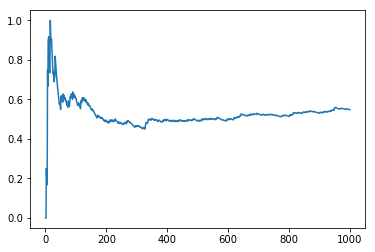

In [146]:
def cumulative_mean(x):
    N = len(x)
    div = range(1,N+1)
    cumsum = np.cumsum(x) 
    return np.divide(cumsum,div)

plt.plot(cumulative_mean(runs))

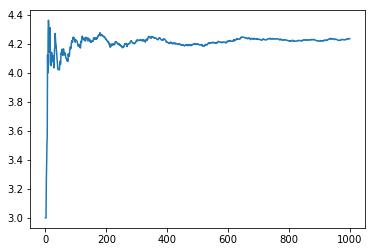

In [147]:
plt.plot(cumulative_mean(orders))

In [148]:
unique, counts = np.unique(runs, return_counts=True)
print(unique)
print(counts)

[ 0.  1.  2.  3.  4.  5.  6.  7.]
[708 146  81  34  23   3   4   1]


In [149]:
unique, counts = np.unique(orders, return_counts=True)
print(unique)
print(counts)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.]
[  9   4   1 312 324 194  83  54  19]


The results are more stablized given 10000 simulated innings.

0.6041
4.2923


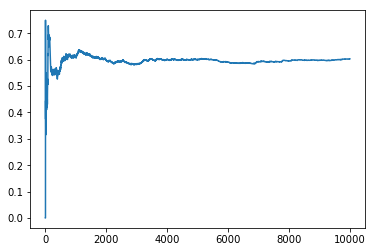

In [142]:
runs,orders = exp_runs(lineup,0,10000)
print(np.mean(runs))
print(np.mean(orders))
plt.plot(cumulative_mean(runs))

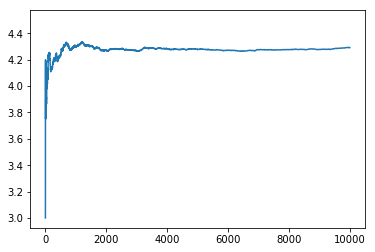

In [143]:
plt.plot(cumulative_mean(orders))

## Full Game Simulation

A game simulation is just 9 innings strung together, making sure that the leadoff hitter for each inning corresponds to where the last one ended.

In [212]:
def game(lineup):
    order = 0
    runs = 0
    for i in range(9):
        inn_runs,order = inning_runs(lineup,order)
        runs = runs+inn_runs
    return runs

In [226]:
game(lineup)

3

In [229]:
def exp_runs_game(lineup,N):
    runs = np.zeros(N)
    for i in range(N):
        runs[i] = game(lineup)
    return runs

An expected runs/game of 4.772 is simulated from a 500 game sample, but the results do not look especially stablised.

4.772


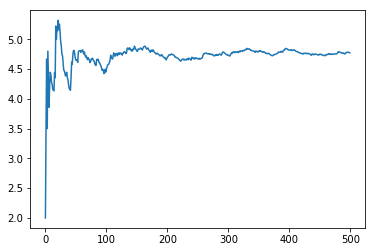

In [250]:
runs_game = exp_runs_game(lineup,N=500)
print(np.mean(runs_game))
plt.plot(cumulative_mean(runs_game))

(array([ 20.,  59.,  54.,  65.,  61.,  61.,  44.,  51.,  29.,  17.,  17.,
          8.,   6.,   3.,   1.,   2.,   1.,   1.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

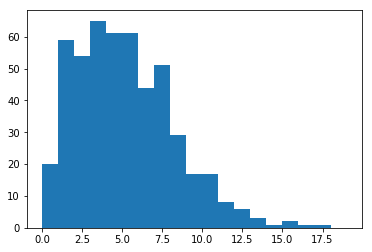

In [238]:
plt.hist(runs_game,bins=range(20))

## Season Sim

A full season sim of 162 games is run 10 times for the test lineup. The results are varied, ranging from 4.61 to 5.49 runs/game. This is a big gap and shows that a larger sample should be used. However, it should be noted that this outlines an important point that should be made. Whatever the results of this lineup optimization exercise, a team's run scoring output over the course of the season could vary a lot. Even if a batting order is a good choice, the results might not line up with that because of bad luck or bad sequencing. However, it is still important to choose the batting order which gives that best shot at optimal production, even if it is somewhat up to chance, which is the goal of this exercise.

In [251]:
for i in range(10):
    runs_game = exp_runs_game(lineup,N=162)
    print(np.mean(runs_game))

4.96913580247
4.61111111111
4.93209876543
4.96913580247
4.9012345679
4.97530864198
5.48765432099
4.61111111111
5.1975308642
5.42592592593


Samples of 1000 games provide tighter results. For reference, the Indians scored 5.05 runs/game in 2017, compared to a 4.65 league average.

https://www.baseball-reference.com/leagues/MLB/2017.shtml

In [252]:
for i in range(10):
    runs_game = exp_runs_game(lineup,N=1000)
    print(np.mean(runs_game))

4.849
4.94
5.141
4.907
4.912
4.728
4.927
4.923
5.045
4.963


In [269]:
lineup_rpg = {}

In [266]:
def lineup_sim(lineup,N):
    print('Lineup: ')
    print(lineup)
    runs_game = exp_runs_game(lineup,N)
    lineup_rpg[lineup] = runs_game
    print('Runs/game: '+str(np.mean(runs_game)))

In [268]:
lineup_1 = ['Francisco Lindor','Jose Ramirez','Michael Brantley','Edwin Encarnacion','Yonder Alonso',
          'Jason Kipnis','Lonnie Chisenhall','Yan Gomes','Bradley Zimmer']
lineup_sim(lineup_1,1000)

Lineup: 
['Francisco Lindor', 'Jose Ramirez', 'Michael Brantley', 'Edwin Encarnacion', 'Yonder Alonso', 'Jason Kipnis', 'Lonnie Chisenhall', 'Yan Gomes', 'Bradley Zimmer']
Runs/game: 4.89


In [276]:
proj[['Name','wOBA']].sort_values(by='wOBA',ascending=False).head(15)

,Name,wOBA
0,Edwin Encarnacion,0.366
1,Francisco Lindor,0.360
2,Jose Ramirez,0.359
3,Michael Brantley,0.350
4,Yonder Alonso,0.345
5,Yandy Diaz,0.339
6,Lonnie Chisenhall,0.326
7,Jason Kipnis,0.325
8,Brandon Guyer,0.323
9,Tyler Naquin,0.319


In [277]:
options = ['Edwin Encarnacion','Francisco Lindor','Jose Ramirez','Michael Brantley','Yonder Alonso',
          'Yandy Diaz','Lonnie Chisenhall','Jason Kipnis','Francisco Mejia']

In [279]:
runners_on_dict = {0:0,1:1,2:1,3:2,4:1,5:2,6:2,7:3}
pbp['RUN_ON'] = pbp['START_BASES_CD'].map(runners_on_dict)
pbp['RUN_ON'].head(5)

0    0
1    0
2    1
3    2
4    2
Name: RUN_ON, dtype: int64

In [296]:
choice = []
for i in range(1000):
    choice.append(list(np.random.choice([0,1,2,3,4],3)))

In [301]:
orders = [[0,1,2],[0,1,3],[0,1,4],[0,2,3],[0,2,4],[0,3,4],[1,2,3],[1,2,4],[1,3,4],[2,3,4]]

In [308]:
a = [0,1,2,3,4]
b = [x for x in a if x not in orders[0]]
b[1] = 5
b

[3, 5]

In [389]:
lineups = []
lineup = options
l = 0
for order in orders:
    top_order = [0,1,2,3,4]
    remain = [x for x in top_order if x not in order]
    for i in remain:
        lineup[order[0]] = 'Francisco Lindor'
        lineup[order[1]] = 'Jose Ramirez'
        lineup[order[2]] = 'Edwin Encarnacion'
        lineup[i] = 'Michael Brantley'
        last = [x for x in remain if x != i]
        lineup[last[0]] = 'Yonder Alonso'
        lineup[5] = 'Yandy Diaz'
        lineup[6] = 'Lonnie Chisenhall'
        lineup[7] = 'Jason Kipnis'
        lineup[8] = 'Francisco Mejia'
        lineups.append(lineup[:])

In [390]:
print(lineups[0])

['Francisco Lindor', 'Jose Ramirez', 'Edwin Encarnacion', 'Michael Brantley', 'Yonder Alonso', 'Yandy Diaz', 'Lonnie Chisenhall', 'Jason Kipnis', 'Francisco Mejia']


In [393]:
lineup_rpg = {}
for lineup in lineups:
    lineup_sim(lineup,10000)

Lineup: 
['Francisco Lindor', 'Jose Ramirez', 'Edwin Encarnacion', 'Michael Brantley', 'Yonder Alonso', 'Yandy Diaz', 'Lonnie Chisenhall', 'Jason Kipnis', 'Francisco Mejia']
Runs/game: 5.091
Lineup: 
['Francisco Lindor', 'Jose Ramirez', 'Edwin Encarnacion', 'Yonder Alonso', 'Michael Brantley', 'Yandy Diaz', 'Lonnie Chisenhall', 'Jason Kipnis', 'Francisco Mejia']
Runs/game: 5.097
Lineup: 
['Francisco Lindor', 'Jose Ramirez', 'Michael Brantley', 'Edwin Encarnacion', 'Yonder Alonso', 'Yandy Diaz', 'Lonnie Chisenhall', 'Jason Kipnis', 'Francisco Mejia']
Runs/game: 4.937
Lineup: 
['Francisco Lindor', 'Jose Ramirez', 'Yonder Alonso', 'Edwin Encarnacion', 'Michael Brantley', 'Yandy Diaz', 'Lonnie Chisenhall', 'Jason Kipnis', 'Francisco Mejia']
Runs/game: 5.071
Lineup: 
['Francisco Lindor', 'Jose Ramirez', 'Michael Brantley', 'Yonder Alonso', 'Edwin Encarnacion', 'Yandy Diaz', 'Lonnie Chisenhall', 'Jason Kipnis', 'Francisco Mejia']
Runs/game: 5.008
Lineup: 
['Francisco Lindor', 'Jose Ramirez',

In [411]:
top_lineup = ['Yonder Alonso', 'Francisco Lindor', 'Jose Ramirez', 'Edwin Encarnacion', 'Michael Brantley', 'Yandy Diaz', 'Lonnie Chisenhall', 'Jason Kipnis', 'Francisco Mejia']
print(top_lineup)

['Yonder Alonso', 'Francisco Lindor', 'Jose Ramirez', 'Edwin Encarnacion', 'Michael Brantley', 'Yandy Diaz', 'Lonnie Chisenhall', 'Jason Kipnis', 'Francisco Mejia']


## Conclusion

In a surprise, the top lineup out of 20 tested across 10,000 games each was the one listed above with 5.296 runs scored per game. Yonder Alonso in the leadoff spot was not at all expected, but that is what can happen if you allow yourself to break convention.

In the end, it seems that different lineups can possibly make a difference, but not as great a difference as would maybe be hoped for. Plus this assumes all sorts of things about the players not being effected by where they are placed in the lineup, which very well could happen. In the end, when lineup differences aren't very great anyway, I will trust Terry Francona. To his credit has shown he is willing to experiment with unconventional batting order decisions such as batting Carlos Santana in the leadoff spot, and he always seems to get the best out of his players.